# Supervised Learning Section

#### Import statements:

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
import numpy as np

#### Loading in joined weekly data:

In [2]:
# Loading in weekly teams stats CSVs.
offense_df = pd.read_csv("Kaggle NFL CSVs/weekly_team_stats_offense.csv")
defense_df = pd.read_csv("Kaggle NFL CSVs/weekly_team_stats_defense.csv")

# Merge to one df. Merge on team, season, week. Use "_off" and "_def" suffixes to differentiate. Origins of
# columns/stats that have the same name in both dfs.
weekly_team_stats = pd.merge(offense_df, defense_df, on = ["team", "season", "week"], suffixes = ("_off", "_def"))

Displaying all columns in the df for reference:

In [3]:
for col in weekly_team_stats.columns:
    print(col)

game_id_off
season
week
team
season_type_off
shotgun
no_huddle
qb_dropback
qb_scramble
total_off_yards
pass_attempts
complete_pass
incomplete_pass
passing_yards
air_yards
receiving_yards
yards_after_catch
rush_attempts
rushing_yards
tackled_for_loss
first_down_pass
first_down_rush
third_down_converted
third_down_failed
fourth_down_converted
fourth_down_failed
rush_touchdown
pass_touchdown
safety_off
interception_off
fumble_off
fumble_lost_off
fumble_forced_off
fumble_not_forced_off
fumble_out_of_bounds_off
total_off_points_off
total_def_points_off
extra_point_off
field_goal_off
kickoff_off
no_play_off
pass_snaps_off
punt_off
qb_kneel_off
qb_spike_off
rush_snaps_off
offense_snaps
st_snaps_off
rush_pct_off
pass_pct_off
home_win_off
home_loss_off
home_tie_off
away_win_off
away_loss_off
away_tie_off
win_off
loss_off
tie_off
record_off
win_pct_off
passing_air_yards
receiving_air_yards
receptions
receiving_touchdown
targets
yps
adot
air_yards_share
target_share
comp_pct
int_pct
pass_td_pct
y

#### Prepare data for a random forest model:

Creating needed binary variables from categorial columns:

In [4]:
# Creating a binary variable representing whether or not teams were playing a regular season game 
# (1 if true, else 0 if false))
weekly_team_stats["regular_season"] = weekly_team_stats["season_type_off"].apply(lambda x: 1 if x == "REG" else 0)

# Creating a column representing whether the team won the game, and columns showing whether the game was a home 
# game or away game.
results_cols = ["home_win_off", "home_loss_off", "home_tie_off", "away_win_off", "away_loss_off", "away_tie_off"]
results_df = weekly_team_stats[results_cols]

home_game_lst = []
won_lst = [] 
for i in range(len(results_df)):
    row = results_df.iloc[i]
    if 1 in row.values[:3]:
        home_game_lst.append(1)
    else:
        home_game_lst.append(0)
    if 1 in [row["home_win_off"], row["away_win_off"]]:
        won_lst.append(1)
    else:
        won_lst.append(0)

weekly_team_stats["home_game"] = home_game_lst
weekly_team_stats["won"] = won_lst

Final filtering of dataframe and inclusion of relevant columns:

In [5]:
# Filtering out ties.
tie_filter_mask = (weekly_team_stats["home_tie_off"] != 1) & (weekly_team_stats["away_tie_off"] != 1)
weekly_team_stats = weekly_team_stats[tie_filter_mask]

# Filtering out rows so that data for the same game does not appear twice (could cause data leakage othrwise).
# Accomplishing this by removing every other duplicate home game.
weekly_team_stats.sort_values(by = ["game_id_off", "home_game"], inplace = True)
weekly_team_stats = weekly_team_stats[[True,False,False,True] * int(len(weekly_team_stats)/4)]
weekly_team_stats.reset_index(inplace = True, drop = True)

# Columns to include.
columns_to_include = ["shotgun",
                      "no_huddle",
                      "qb_dropback",
                      "qb_scramble",
                      "pass_attempts",
                      "complete_pass",
                      "incomplete_pass",
                      "air_yards",
                      "yards_after_catch",
                      "rush_attempts",
                      "rushing_yards",
                      "tackled_for_loss",
                      "first_down_pass",
                      "first_down_rush",
                      "third_down_converted",
                      "third_down_failed",
                      "fourth_down_converted",
                      "fourth_down_failed",
                      "fumble_forced_off",
                      "fumble_not_forced_off",
                      "interception_off",
                      "interception_def",
                      "fumble_forced_def",
                      "fumble_not_forced_def",
                      "solo_tackle",
                      "assist_tackle",
                      "sack",
                      "qb_hit",
                      "home_game",
                      "regular_season",
                      "won",
                      "game_id_off"]

weekly_team_stats = weekly_team_stats[columns_to_include]

Split to train and test sets:

In [6]:
# Save game ids for future reference.
game_ids = weekly_team_stats["game_id_off"]

# Separate X and y.
X = weekly_team_stats.drop(columns = ["won", "game_id_off"])
y = weekly_team_stats["won"]

# Perform split.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

#### Model analysis:

Train initial models:

In [7]:
# Initialize models.
RandomForest = RandomForestClassifier(random_state = 42)
GradientBoosting = GradientBoostingClassifier(random_state = 42)
LogisticReg = LogisticRegression(random_state = 42, max_iter = 1000)

# Fit models.
RandomForest.fit(X_train, y_train)
GradientBoosting.fit(X_train, y_train)
scaler = StandardScaler() # (Scaling data for the logistic regression).
scaler.fit(X_train) 
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns, index = X_test.index)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns, index = X_train.index)
LogisticReg.fit(X_train_scaled, y_train)

# Calculating and outputting metrics.
output_df = pd.DataFrame()
for model in [RandomForest, GradientBoosting, LogisticReg]:
    y_pred = model.predict(X_test) if model != LogisticReg else model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    output_df = pd.concat([output_df, pd.DataFrame({"Accuracy": [accuracy],
                                                   "F1 Score": [f1], 
                                                   "Precision": [precision], 
                                                   "Recall": [recall]})])

output_df["Model"] = ["Random Forest", "GBDT", "Logistic Regression"]
output_df = output_df[output_df.columns[::-1]]

display(output_df)

,Model,Recall,Precision,F1 Score,Accuracy
0,Random Forest,0.844098,0.809829,0.826609,0.820542
0,GBDT,0.857461,0.820896,0.838780,0.832957
0,Logistic Regression,0.886414,0.839662,0.862405,0.856659


Hyperparameter tuning:

In [8]:
# Random forest tuning:
param_grid = {"n_estimators": [10, 100, 1000, 2000],
              "max_depth": [2, 5, 10, 20]}
grid_search = GridSearchCV(RandomForestClassifier(random_state = 42), param_grid)
grid_search.fit(X_train, y_train)
print(grid_search.cv_results_)
print("Best model:", grid_search.best_params_, "Score:", grid_search.best_score_)

{'mean_fit_time': array([ 0.0255466 ,  0.21853337,  2.19742117,  4.29603381,  0.03733501,
        0.31399841,  2.99529133,  6.04357305,  0.04611301,  0.42395387,
        4.5268878 ,  8.90788555,  0.05324173,  0.52921171,  5.285109  ,
       10.07878928]), 'std_fit_time': array([0.00304706, 0.01099721, 0.07352377, 0.12643443, 0.00303808,
       0.00807544, 0.01473107, 0.10512641, 0.00513599, 0.02661223,
       0.07205745, 0.1592473 , 0.00503795, 0.01801291, 0.17748559,
       0.39693764]), 'mean_score_time': array([0.00388417, 0.01368632, 0.10002031, 0.18998432, 0.00497293,
       0.01471605, 0.11164522, 0.22334394, 0.00389929, 0.0166172 ,
       0.14847059, 0.29906034, 0.0040401 , 0.01912603, 0.17315035,
       0.32824454]), 'std_score_time': array([0.00033923, 0.00143787, 0.00398687, 0.0112451 , 0.00064721,
       0.0019676 , 0.00633718, 0.0057964 , 0.00053502, 0.00171168,
       0.00494578, 0.01200949, 0.0003783 , 0.00222318, 0.00855957,
       0.02191916]), 'param_max_depth': masked

In [9]:
# Gradient boosted decision tree tuning:
param_grid = {"max_depth": [2, 5, 10, 20],
              "learning_rate": [0.01, 0.1, 1]}
grid_search = GridSearchCV(GradientBoostingClassifier(random_state = 42), param_grid)
grid_search.fit(X_train, y_train)
print(grid_search.cv_results_)
print("Best model:", grid_search.best_params_, "Score:", grid_search.best_score_)

{'mean_fit_time': array([0.5248611 , 1.31888905, 3.21928878, 3.34207134, 0.52571459,
       1.31353235, 3.5857935 , 3.31890006, 0.5333827 , 1.31359267,
       1.34218965, 0.64655986]), 'std_fit_time': array([0.00726038, 0.01628536, 0.04249082, 0.13356431, 0.0085542 ,
       0.01415106, 0.05394457, 0.12101721, 0.01255752, 0.03928164,
       0.05344326, 0.02137275]), 'mean_score_time': array([0.00443139, 0.0055263 , 0.00824933, 0.00799928, 0.00414762,
       0.00554867, 0.01009836, 0.00979872, 0.00404868, 0.00585418,
       0.00604534, 0.00426331]), 'std_score_time': array([0.00066101, 0.00061219, 0.00126416, 0.00061326, 0.00058637,
       0.00061799, 0.00114459, 0.00090611, 0.0006331 , 0.00111729,
       0.0004676 , 0.00091398]), 'param_learning_rate': masked_array(data=[0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1, 1, 1, 1, 1],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value='?',
            dtyp

In [10]:
# Logisitic regression tuning:
param_grid = {"C": [0.01, 0.1, 1, 10, 100], 
              "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}
grid_search = GridSearchCV(LogisticRegression(random_state = 42, max_iter = 1000), param_grid)
grid_search.fit(X_train_scaled, y_train)
print(grid_search.cv_results_)
print("Best model:", grid_search.best_params_, "Score:", grid_search.best_score_)

{'mean_fit_time': array([1.13829737, 0.20297236, 0.06506224, 0.13690586, 0.15571232,
       0.9778173 , 0.53619971, 0.08408651, 0.14145331, 0.19361234,
       2.27027297, 0.73703122, 0.11424036, 0.19662299, 0.23321977,
       2.79334354, 1.33402848, 0.16789832, 0.1632834 , 0.22762628,
       3.1951889 , 1.1373425 , 0.13999634, 0.19676867, 0.23118982]), 'std_fit_time': array([0.49242082, 0.0870176 , 0.03979422, 0.02724852, 0.04265229,
       0.11754476, 0.19180734, 0.03366112, 0.04122316, 0.01846905,
       0.88160786, 0.17837941, 0.03585345, 0.0132975 , 0.02809533,
       0.55251753, 0.18855847, 0.03768657, 0.01616775, 0.0188879 ,
       0.30982039, 0.58029022, 0.03999   , 0.01445278, 0.02140504]), 'mean_score_time': array([0.02211661, 0.04087329, 0.03923526, 0.03122482, 0.02319865,
       0.03887711, 0.02106442, 0.05939908, 0.01949291, 0.0073339 ,
       0.02396712, 0.04014115, 0.00685372, 0.00967803, 0.01950703,
       0.02478538, 0.06697674, 0.0284533 , 0.02738371, 0.01916442,
     

Comparing best models from hyperprameter tuning:

In [11]:
# Create an empty df for output and list of models to test.
model_compare = pd.DataFrame()
testing_models = [RandomForestClassifier(n_estimators = 2000, max_depth = 20, random_state = 42),
                  GradientBoostingClassifier(learning_rate = 0.1, max_depth = 2, random_state = 42),
                  LogisticRegression(random_state = 42, max_iter = 1000)]

# Populate df with cross validation metrics.
for model in testing_models:
    cross_val_X, cross_val_y = (X_train, y_train) if testing_models.index(model) != 2 else (X_train_scaled, y_train)
    
    cross_val_accuracy = cross_val_score(model, cross_val_X, cross_val_y, scoring = "accuracy")
    cross_val_f1 = cross_val_score(model, cross_val_X, cross_val_y, scoring = "f1")
    cross_val_precision = cross_val_score(model, cross_val_X, cross_val_y, scoring = "precision")
    cross_val_recall = cross_val_score(model, cross_val_X, cross_val_y, scoring = "recall")
    
    model_compare = pd.concat([model_compare, pd.DataFrame({"F1 Score mean": [np.mean(cross_val_f1)],
                                                    "F1 Score std": [np.std(cross_val_f1)], 
                                                    "Precision mean": [np.mean(cross_val_precision)],
                                                    "Precision std": [np.std(cross_val_precision)], 
                                                    "Recall mean": [np.mean(cross_val_recall)],
                                                    "Recall std": [np.std(cross_val_recall)],
                                                    "Accuracy mean": [np.mean(cross_val_accuracy)],
                                                    "Accuracy std": [np.std(cross_val_accuracy)]})])

model_compare["Model"] = ["Random Forest", "GBDT", "Logistic Regression"]
model_compare = model_compare[model_compare.columns[::-1]]

model_compare

,Model,Accuracy std,Accuracy mean,Recall std,Recall mean,Precision std,Precision mean,F1 Score std,F1 Score mean
0,Random Forest,0.012655,0.841977,0.021352,0.849539,0.010082,0.834329,0.013737,0.841764
0,GBDT,0.018142,0.847622,0.025885,0.854116,0.021165,0.841078,0.018340,0.847298
0,Logistic Regression,0.011271,0.865683,0.024543,0.870066,0.015810,0.860694,0.012069,0.865041


Best model feature importance and ablation analysis:

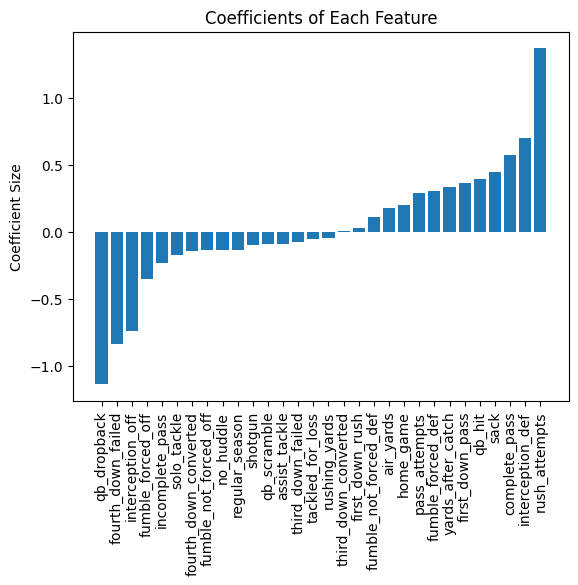

In [12]:
# Save a best model for future use (using LogisitcReg b/c solver has little impact on accuracy):
best_model = LogisticReg

# Plot the feature importances as a bar graph:
plot_data = dict(sorted(zip(X_train.columns,best_model.coef_[0]), key = lambda x: x[1]))

plt.bar(plot_data.keys(), plot_data.values())
plt.xticks(rotation = 90)
plt.title("Coefficients of Each Feature")
plt.ylabel("Coefficient Size")
plt.show()

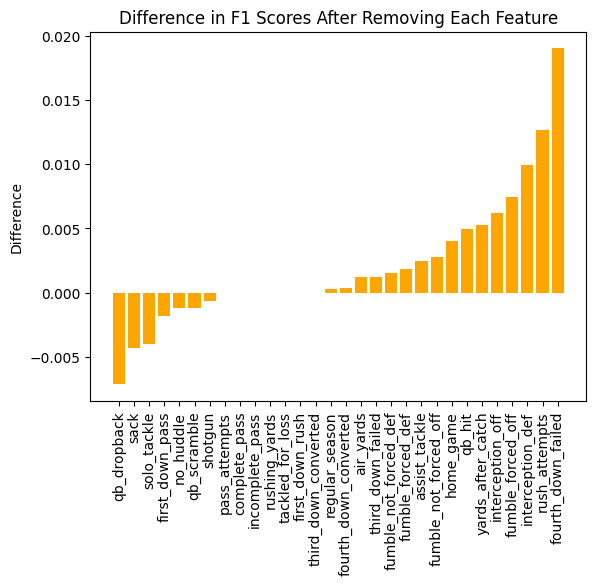

In [13]:
# Feature sensitivity analysis:

# Go through the features, and train the model without each one. Save the f1 score difference.
f1_scores = []
base_f1 = output_df.loc[output_df["Model"] == "Logistic Regression", "F1 Score"][0]
for feature in X_train.columns:
    X_train_no_feature = X_train_scaled.drop(columns = feature)
    X_test_no_feature = X_test_scaled.drop(columns = feature)
    model = LogisticRegression(random_state = 42, max_iter = 1000)
    model.fit(X_train_no_feature, y_train)
    y_pred = model.predict(X_test_no_feature)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(base_f1 - f1)

# Plot the results:
plot_data = dict(sorted(zip(X_train.columns, f1_scores), key = lambda x: x[1]))

plt.bar(plot_data.keys(), plot_data.values(), color = "orange")
plt.xticks(rotation = 90)
plt.title("Difference in F1 Scores After Removing Each Feature")
plt.ylabel("Difference")
plt.show()

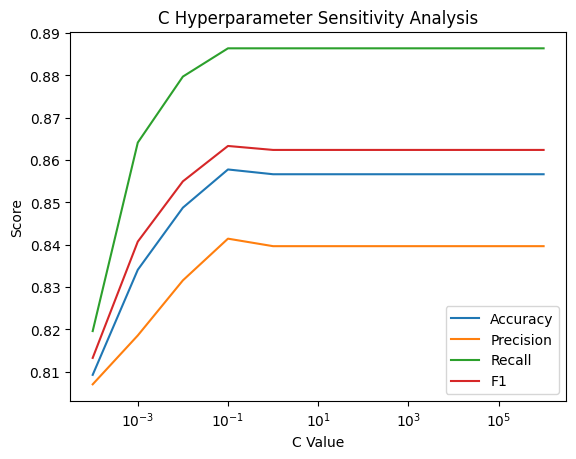

In [14]:
# C hyperparamter sensitivity analysis:

# Test different C values:
Cs_to_test = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]

f1_scores, accuracy_scores, precision_scores, recall_scores = [], [], [], []
for C in Cs_to_test:
    model = LogisticRegression(random_state = 42, max_iter = 1000, C = C)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    f1_scores.append(f1_score(y_test, y_pred))
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))

# Plot the results
plt.plot(Cs_to_test, accuracy_scores, label = "Accuracy")
plt.plot(Cs_to_test, precision_scores, label = "Precision")
plt.plot(Cs_to_test, recall_scores, label = "Recall")
plt.plot(Cs_to_test, f1_scores, label = "F1")
plt.xscale("log")
plt.title("C Hyperparameter Sensitivity Analysis")
plt.xlabel("C Value")
plt.ylabel("Score")
plt.legend()
plt.show()

Failure analysis:

In [15]:
# finding cases where the model was confident, yet still wrong.
confidences = best_model.decision_function(X_test_scaled)
predictions = best_model.predict(X_test_scaled)

predictions_df = pd.DataFrame({"Confidence": confidences, "Prediction": predictions, "Actual": y_test})

predictions_df.sort_values(by = "Confidence", ascending = False, inplace = True)

predictions_df = predictions_df[predictions_df["Prediction"] != predictions_df["Actual"]]

predictions_df

,Confidence,Prediction,Actual
798,3.985237,1,0
88,3.960652,1,0
2463,3.838758,1,0
2383,3.802470,1,0
2717,3.705582,1,0
...,...,...,...
393,-2.106969,0,1
1222,-2.161337,0,1
2819,-2.379074,0,1
1037,-2.776936,0,1


In [16]:
# Getting information to interpret which values in false predictions are generally high or low 

pd.DataFrame([scaler.mean_, scaler.scale_], index = ["Mean", "Standard Deviation"], columns = X_train.columns)

,shotgun,no_huddle,qb_dropback,qb_scramble,pass_attempts,complete_pass,incomplete_pass,air_yards,yards_after_catch,rush_attempts,...,interception_off,interception_def,fumble_forced_def,fumble_not_forced_def,solo_tackle,assist_tackle,sack,qb_hit,home_game,regular_season
Mean,43.436795,7.078631,38.773890,1.709180,33.869451,22.000752,11.868698,283.101956,113.416102,26.645222,...,0.852897,0.81678,0.811889,0.410835,39.098570,12.234763,2.337096,5.262603,0.505643,0.959744
Standard Deviation,13.594082,9.515513,8.751203,1.722925,8.211824,5.957146,4.417506,98.599835,43.929906,7.582415,...,0.960366,0.94263,0.926969,0.662714,7.527081,5.677484,1.692941,2.832727,0.499968,0.196559


In [17]:
# Showing some of those case data.

# First 10 most confident false positives:
most_conf_fp = predictions_df[:10].index
X_test.loc[most_conf_fp]

,shotgun,no_huddle,qb_dropback,qb_scramble,pass_attempts,complete_pass,incomplete_pass,air_yards,yards_after_catch,rush_attempts,...,interception_off,interception_def,fumble_forced_def,fumble_not_forced_def,solo_tackle,assist_tackle,sack,qb_hit,home_game,regular_season
798,70,4,36,1,32,19,13,283,57,30,...,2,4,1,2,39,16,5,8,0,0
88,21,3,36,0,32,23,9,269,163,32,...,1,3,0,0,34,5,1,10,0,1
2463,35,0,26,0,25,19,6,193,117,39,...,1,1,2,0,35,14,0,6,1,1
2383,49,2,45,1,41,25,16,298,211,32,...,0,2,2,1,34,14,3,5,1,1
2717,31,4,32,4,26,22,4,146,120,37,...,1,0,2,0,42,5,2,5,1,1
3392,40,3,30,1,28,25,3,137,145,31,...,0,1,0,0,31,13,1,3,0,1
48,51,1,32,4,25,15,10,201,81,35,...,0,1,0,0,43,8,7,11,0,1
2872,24,3,26,2,22,17,5,223,52,28,...,0,2,1,0,45,22,4,5,0,1
3001,42,4,32,1,31,21,10,309,86,30,...,0,1,0,0,43,10,3,4,1,1
194,16,4,24,1,20,16,4,182,90,35,...,1,0,2,1,28,28,3,7,0,1


In [18]:
# Fetch Game IDs
game_ids.loc[most_conf_fp] 

798      2014_20_GB_SEA
88      2012_06_OAK_ATL
2463     2021_04_NYG_NO
2383     2020_17_LV_DEN
2717    2022_02_NYJ_CLE
3392    2024_09_MIA_BUF
48      2012_04_CAR_ATL
2872    2022_13_DEN_BAL
3001    2023_02_NYG_ARI
194     2012_14_BAL_WAS
Name: game_id_off, dtype: object

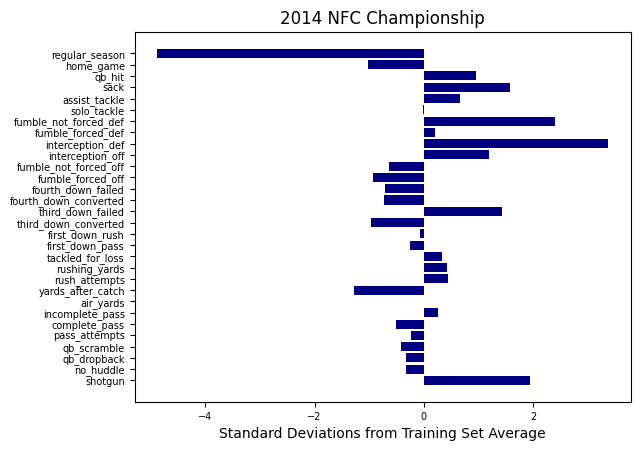

In [19]:
# Visualize deviation from training average
plt.barh(width = X_test_scaled.loc[798], y = X_test.columns, color = "navy")
plt.xlabel("Standard Deviations from Training Set Average")
plt.title("2014 NFC Championship")
plt.tick_params(labelsize = 7)
plt.show()

The first false positive is likely caused by the relatively high number of defensive interceptions and fumble_not_forced_def. More regularization could help bring down the weight of this in this case and allow for a correct prediction.

In [20]:
# 10 most confident false negatives:
most_conf_fn = predictions_df[:-11:-1].index
X_test.loc[most_conf_fn]

,shotgun,no_huddle,qb_dropback,qb_scramble,pass_attempts,complete_pass,incomplete_pass,air_yards,yards_after_catch,rush_attempts,...,interception_off,interception_def,fumble_forced_def,fumble_not_forced_def,solo_tackle,assist_tackle,sack,qb_hit,home_game,regular_season
3017,64,10,50,4,43,22,21,522,77,26,...,1,0,0,0,42,10,4,6,1,1
1037,52,2,46,4,37,23,14,259,97,24,...,1,0,1,0,52,6,1,2,1,1
2819,61,24,58,0,58,36,22,271,127,20,...,0,0,0,2,38,11,4,8,1,1
1222,47,1,39,1,33,24,9,273,61,19,...,1,0,1,0,36,11,1,4,0,1
393,53,4,55,1,50,34,16,345,182,9,...,1,1,2,0,51,9,2,2,1,1
2862,51,7,54,2,47,35,12,176,175,13,...,0,1,1,0,39,15,1,1,0,1
1778,24,2,29,1,26,11,15,250,31,29,...,0,0,0,0,51,7,1,4,0,1
1263,63,1,41,3,33,21,12,257,68,28,...,2,0,0,0,34,6,1,3,1,1
2714,47,1,51,1,48,36,12,362,220,18,...,2,0,0,1,29,13,0,0,0,1
3536,71,52,40,4,35,24,11,199,132,33,...,0,0,0,1,30,12,1,1,0,0


In [21]:
# Fetch Game IDs
game_ids.loc[most_conf_fn]

3017      2023_03_NO_GB
1037     2015_16_SD_OAK
2819      2022_09_LA_TB
1222     2016_11_MIA_LA
393     2013_09_MIN_DAL
2862    2022_12_LAC_ARI
1778     2018_13_ARI_GB
1263    2016_14_CHI_DET
2714    2022_02_MIA_BAL
3536     2024_19_WAS_TB
Name: game_id_off, dtype: object

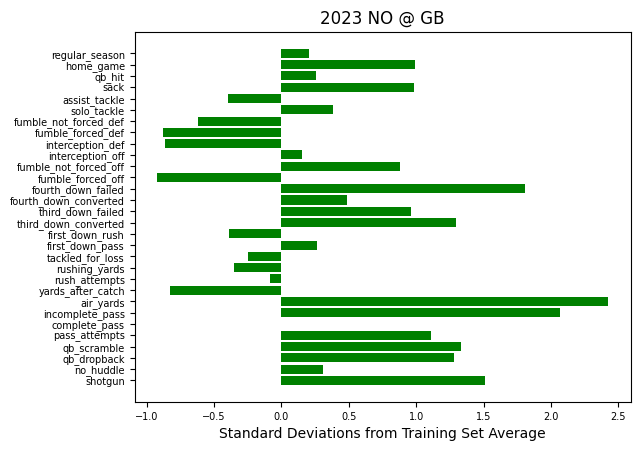

In [22]:
plt.barh(width = X_test_scaled.loc[3017], y = X_test.columns, color = "green")
plt.title("2023 NO @ GB")
plt.tick_params(labelsize = 7)
plt.xlabel("Standard Deviations from Training Set Average")
plt.show()

This game featured a low opposing turnovers and many failed fourth downs, in particular, yet the ground was made up in air yards. This game represents a late comeback that could be an unusual circumstance edge case.

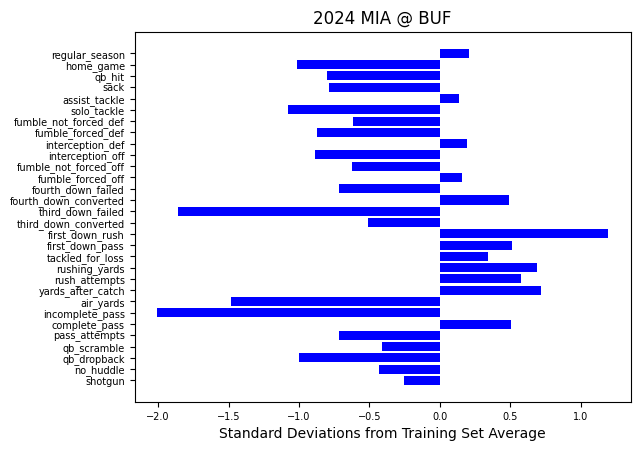

In [23]:
# Looking at another false positive, 2024 Miami at Buffalo.

plt.barh(width = X_test_scaled.loc[3392], y = X_test.columns, color = "blue")
plt.title("2024 MIA @ BUF")
plt.tick_params(labelsize = 7)
plt.xlabel("Standard Deviations from Training Set Average")
plt.show()

Not a clear pattern here, simply could be because of random noise. It seems like a few stats spread out are doing a lot of the heavy lifiting in terms of making this model predict a Dolphins win. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=32f663d2-ff71-4fff-a76e-068fa019f967' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>